<a href="https://colab.research.google.com/github/mantzaris/teddyCode/blob/main/questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

In [ ]:
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("LightGraphs")
import Pkg; Pkg.add("LaTeXStrings")
import Pkg; Pkg.add("Flux")
import Pkg; Pkg.add("GraphRecipes")
import Pkg; Pkg.add("GraphPlot")
import Pkg; Pkg.add("StatsBase")
import Pkg; Pkg.add("Distributions")
import Pkg; Pkg.add("OneHotArrays")
import Pkg; Pkg.add("InvertedIndices")
import Pkg; Pkg.add("ROCAnalysis")

In [93]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings
using Flux
using GraphRecipes
using GraphPlot
using StatsBase
using Distributions
using OneHotArrays
using Statistics
using InvertedIndices
using ROCAnalysis

In [169]:
#this function can create a sparce matrix radomly populated
#percentage = the population percentage
#matrix is the sparse matrix we want to populate

function populate_sparse_matrix(percentage, matrix)
  seed = 1
    for i in range(1, percentage* size(matrix, 1)* size(matrix, 2))
      seed += 1
      Random.seed!(seed)
      row_index =  rand(1: size(matrix, 1))    
      col_index =  rand(1: size(matrix, 2))
      while row_index == col_index
        row_index =  rand(1: size(matrix, 1))    
        col_index =  rand(1: size(matrix, 2))
      end
      if  matrix[floor(Int64, row_index), floor(Int64, col_index)] == 1
        row_index =  rand(1: size(matrix, 1))    
        col_index =  rand(1: size(matrix, 2))
        while row_index == col_index
          row_index =  rand(1: size(matrix, 1))    
          col_index =  rand(1: size(matrix, 2))
        end
        matrix[floor(Int64, row_index), floor(Int64, col_index)] = 1
      else 
        matrix[floor(Int64, row_index), floor(Int64, col_index)] = 1
      end 
    end  
  return matrix 
  print(matrix)
end

populate_sparse_matrix (generic function with 2 methods)

In [170]:
#test the validity of the function populate_sparse_matrix
populate = 0.1 #(10%)
x_dim = 10
y_dim = 10
matrix = spzeros(10, 10)
populate_sparse_matrix(populate, matrix)

10×10 SparseMatrixCSC{Float64, Int64} with 10 stored entries:
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0  1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0
 1.0   ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 

In [100]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end


A2S (generic function with 1 method)

In [101]:
function A2k(SMat,k)
    return SMat^k
end


A2k (generic function with 1 method)

In [105]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5

5

In [171]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:3] #[10^1,10^2,10^3,10^4,10^5]
populate = 0.1
for i in range(1, length(NN))
    dims = NN[i]
    matrix = spzeros(dims, dims)
    AA = populate_sparse_matrix(populate, matrix);
    println("10^$i done")
    bb = @benchmark A2S($AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],bb.memory/10^6)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end


10^1 done
10^2 done
10^3 done


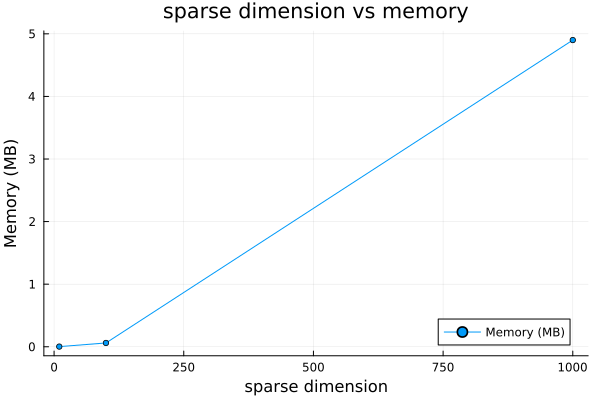

In [172]:
plot(NN, # x-axis
    benchmarkDicts["memory"], # yaxis
    markershape=:circle, 
    markersize=3,
    title = "sparse dimension vs memory",
    xlabel = "sparse dimension",
    label = "Memory (MB)",
    legend=:bottomright,
    ylabel = "Memory (MB)")

In [137]:

function randomPopulateMat(mat,symmetric=true)
    for ii = 1:round(Int, percPopulate*size(mat)[1] )
        row_tmp = rand( 1:size(mat)[1] )
        col_tmp = rand( 1:size(mat)[1] )
        if( row_tmp == col_tmp )
            col_tmp = rand( deleteat!( collect(1:size(mat)[1]), row_tmp ) )            
        end
        mat[row_tmp,col_tmp] = 1
        if(symmetric == true)
            mat[col_tmp,row_tmp] = 1
        end
    end
    return mat
end



randomPopulateMat (generic function with 3 methods)

In [145]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:3] #[10^1,10^2,10^3,10^4,10^5]
percPopulate = 0.1
for ii in 1:length(NN)
    NNtmp = NN[ii]
    AA = spzeros(NNtmp,NNtmp);
    AA = randomPopulateMat(AA);
    println("10^$ii is done")
    bb = @benchmark A2S($AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],bb.memory/10^6)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end


10^1 is done
10^2 is done
10^3 is done


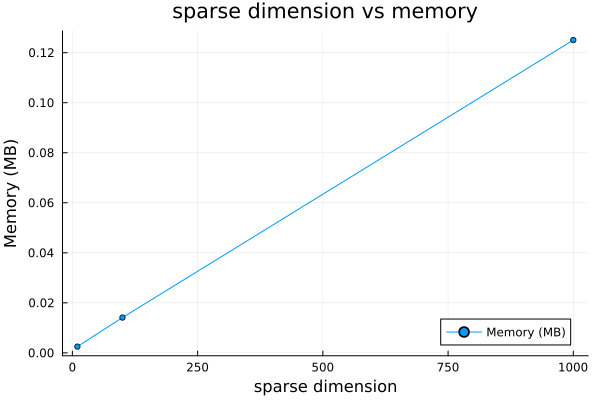

In [146]:
plot(NN, # x-axis
    benchmarkDicts["memory"], # yaxis
    markershape=:circle, 
    markersize=3,
    title = "sparse dimension vs memory",
    xlabel = "sparse dimension",
    label = "Memory (MB)",
    legend=:bottomright,
    ylabel = "Memory (MB)")